# Download data

In [1]:
!pip install yfinance

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import yfinance as yf

In [3]:
spy_df=yf.download('PTC', interval='1wk')

[*********************100%***********************]  1 of 1 completed


In [4]:
spy_df=spy_df[['Adj Close']].copy()

In [5]:
spy_df.isna().sum()

Adj Close    5
dtype: int64

In [6]:
spy_df.head()

,Adj Close
Date,
1989-12-04,1.822917
1989-12-11,1.822917
1989-12-18,1.875000
1989-12-25,2.187500
1990-01-01,2.265625


In [7]:
spy_df.shape

(1704, 1)

In [8]:
spy_df.isna().sum()

Adj Close    5
dtype: int64

In [9]:
spy_df.dropna(inplace=True)

In [10]:
spy_df.describe()

,Adj Close
count,1699.000000
mean,35.729383
std,30.496351
min,1.692708
25%,15.497500
50%,23.620001
75%,48.565001
max,152.690002


# Analyse Data, find Stationnary

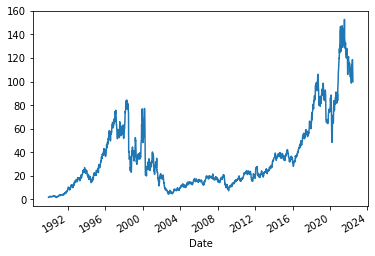

In [11]:
spy_df['Adj Close'].plot();

**As one can see the Timeseries is clearly not stationnary, try to work on the diffs?**

In [12]:
spy_df['diffs']=spy_df['Adj Close'].diff()

In [13]:
spy_df.describe()['diffs']

count    1698.000000
mean        0.057754
std         2.700761
min       -32.500000
25%        -0.680000
50%         0.076563
75%         0.840000
max        15.089996
Name: diffs, dtype: float64

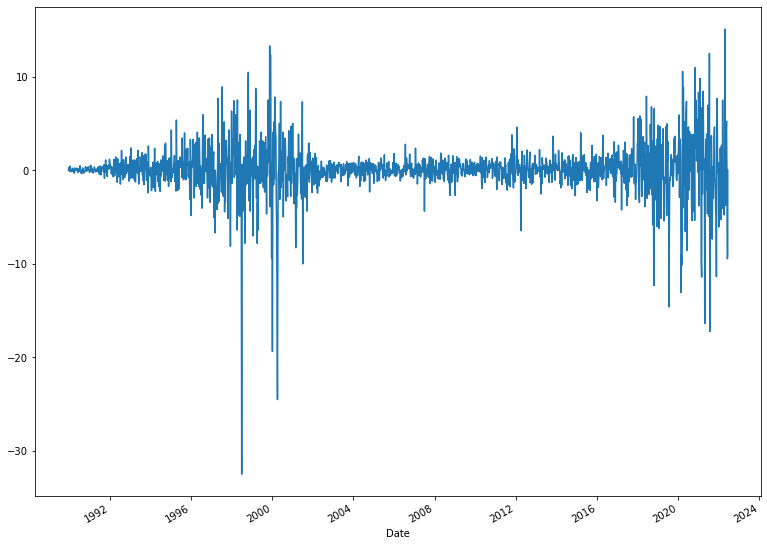

In [14]:
spy_df['diffs'].plot(figsize=(13,10));

**The diffs timeseries is somewhat stationnary, let's work with this**

# Let's build baselines

## The Always predict t-1

In [15]:
spy_df.shape

(1699, 2)

Let's make the last 350 the test set

In [16]:
testset=spy_df['diffs'].iloc[-350:]

In [17]:
trainset=spy_df['diffs'].iloc[:-350]

In [18]:
preds=testset.shift(1)

In [19]:
preds[0]=trainset[-1]

In [20]:
(preds.index==testset.index).all()

True

<AxesSubplot:xlabel='Date'>

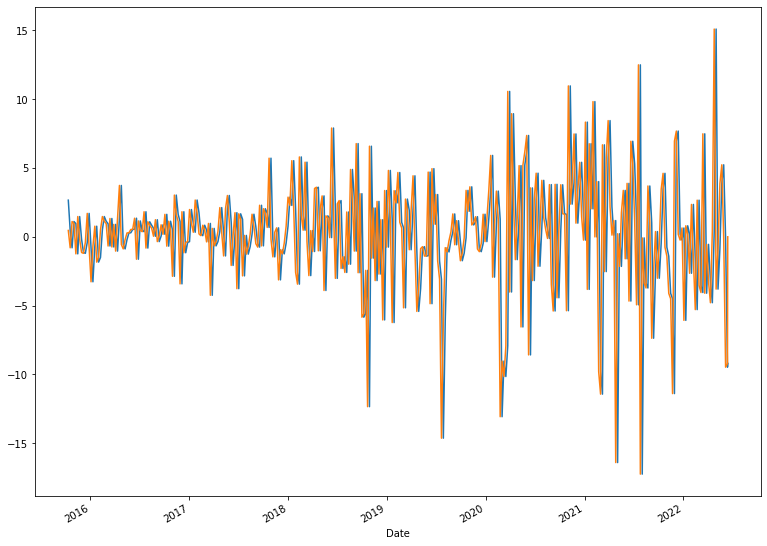

In [21]:
preds.plot(figsize=(13,10))
testset.plot()

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
rmse_baseline=mean_squared_error(testset,preds,squared=False)
rmse_baseline

5.783275718612739

# Autocorrelation 

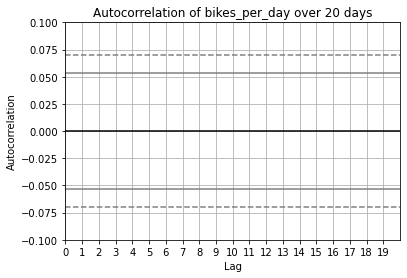

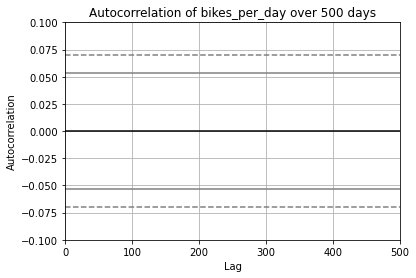

In [24]:
#bikes_per_day = bike_df.resample('d').sum()['Fremont Bridge Total']

plt.figure()
pd.plotting.autocorrelation_plot(trainset)
plt.xlim((0, 20))
plt.ylim((-.1, .1))
plt.xticks(range(20))
plt.title('Autocorrelation of bikes_per_day over 20 days')

plt.figure()
pd.plotting.autocorrelation_plot(trainset)
plt.xlim((0,500))
plt.ylim((-.1, .1))
plt.title('Autocorrelation of bikes_per_day over 500 days');

In [25]:
for i in range(1,30):
    print(i, trainset.autocorr(i))

1 0.10435154007852097
2 0.10576186000350732
3 0.03773429490577755
4 -0.05048087319783743
5 -0.0656618912651526
6 -0.04489771619724594
7 -0.07782455267596766
8 -0.10622675580311401
9 -0.03223845993857259
10 -0.05019717199762369
11 0.029962091228278163
12 0.054593914629199776
13 0.08293543302806924
14 0.05590477793348943
15 0.059600306926320505
16 -0.03723270280614104
17 -0.09253414007793809
18 -0.061751270987909966
19 -0.012569614549976902
20 -0.07883962100433424
21 -0.11494941938658204
22 -0.010139820460979743
23 -0.038025256816326757
24 -0.04052979163725494
25 0.017419785639321096
26 -0.024712325976651284
27 -0.013694078601743466
28 0.01571360399709488
29 0.029670884424352745


In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [27]:
trainset[0]

nan

In [28]:
trainset.dropna(inplace=True)

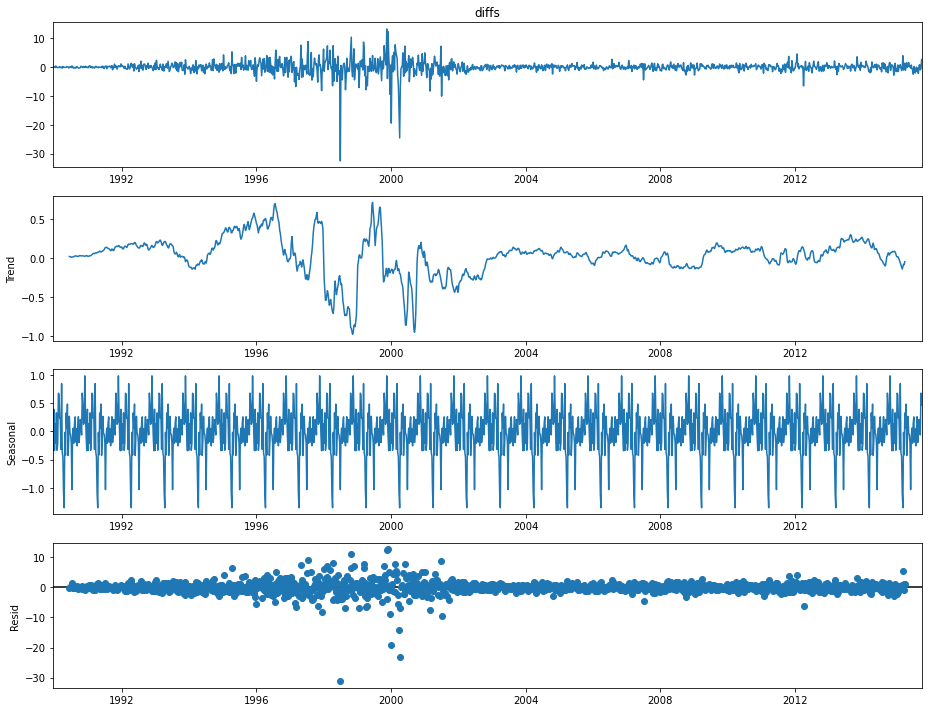

In [29]:
res=seasonal_decompose(trainset)
f=res.plot()
f.set_size_inches((13,10))
f.tight_layout();

In [30]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

/Users/peng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/peng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


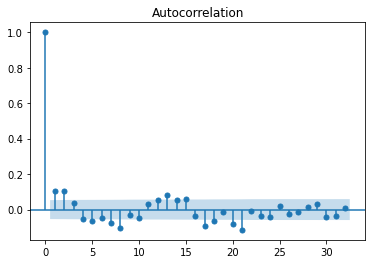

In [31]:
plot_acf(trainset);

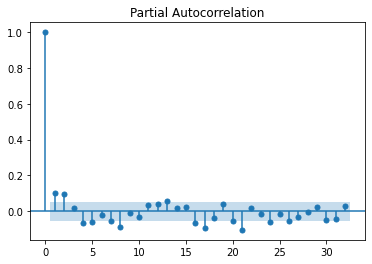

In [32]:
plot_pacf(trainset);

**There is no Autocorrelation what so ever that we can eventually use, it's not so clear the model based on assumptions such as autocorrelation will perform well**

# Arima

In [33]:
from statsmodels.tsa.arima.model import ARIMA

In [34]:
history=trainset.to_list()
predictions=[]
for t in range(len(testset)):
    model=ARIMA(history,order=(2,1,0))
    model_fit=model.fit()
    predictions.append(model_fit.forecast())
    history.append(testset[t])

In [35]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1697
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4286.493
Date:                Wed, 15 Jun 2022   AIC                           8578.986
Time:                        16:30:31   BIC                           8595.294
Sample:                             0   HQIC                          8585.024
                               - 1697                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6831      0.010    -65.065      0.000      -0.704      -0.663
ar.L2         -0.2968      0.013    -22.815      0.000      -0.322      -0.271
sigma2         9.1765      0.113     81.004      0.000       8.954       9.399
===================================================================================
Ljung-Box (L1) (Q):                   2.86   Jarque-Bera (JB):             12986.56
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -0.71
Prob(H) (two-sided):                  0.13   Kurtosis:                        16.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
predictions=[p[0] for p in predictions]

In [37]:
predictions=pd.Series(data=predictions,index=testset.index)

In [38]:
ar_rmse=mean_squared_error(testset,predictions,squared=False)

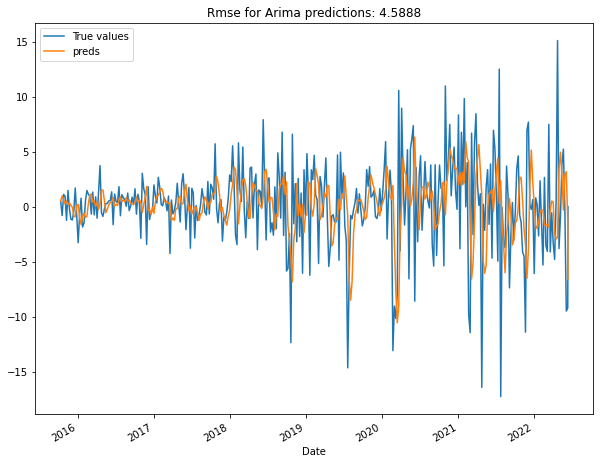

In [39]:
plt.figure(figsize=(10,8))
testset.plot(label='True values')
predictions.plot(label='preds')
plt.title(f'Rmse for Arima predictions: {ar_rmse:.4f}')
plt.legend();

In [40]:
rmse_baseline-ar_rmse

1.1944262796910223

In [41]:
def init_table(ds_true,predictions):
    df['Prediction (of diff)'] = predictions
    df['% change'] = 0.0
    df['Prediction (of % change)'] = 0.0
    df['Recommandation'] = 0
    df['Money end of day'] = 0
    df['Nb of stocks'] = 0
    df['Benefit/day in $'] = 0
    df['cash'] = 0
    return df

In [55]:
def money_end_day(df):
    display(df)
    df['Money end of day'][0] = 1000
    for i in range (len(df)):
        df['Prediction (of % change)'][i] = df['Prediction (of diff)'][i]/df['Adj Close'][i]* 100
    
    for i in range (len(df) - 1):
        df['% change'][i+1] = df['diffs'][i+1]/df['Adj Close'][i]* 100
        #if (df['diffs'][i+1] > 0):
        if (df['Prediction (of diff)'][i+1] > 0):
            n_stocks = df['Money end of day'][i]//df['Adj Close'][i]
            cash = df['Money end of day'][i] - n_stocks * df['Adj Close'][i]
            df['Money end of day'][i+1] = n_stocks * df['Adj Close'][i+1] + cash
            print("Buy!", df['Money end of day'][i], df['Money end of day'][i+1])
            df['Nb of stocks'][i] = n_stocks
            df ['cash'][i] = cash
            
        else:
            df['Nb of stocks'][i] = df['Nb of stocks'][i-1]
            df ['cash'][i] = df ['cash'][i-1]
            df['Money end of day'][i+1] = df['Money end of day'][i]
            print("Do not buy!", df['Money end of day'][i], df['Money end of day'][i+1])
            
    df['Benefit/day in $'][i+1] = df['Money end of day'][i+1] - df['Money end of day'][i]

In [56]:
def recommendation(df):
    df['Recommandation'] = df['Prediction (of diff)'] > 0

In [61]:
display(spy_df)

,Adj Close,diffs
Date,,
1989-12-04,1.822917,NaN
1989-12-11,1.822917,0.000000
1989-12-18,1.875000,0.052083
1989-12-25,2.187500,0.312500
1990-01-01,2.265625,0.078125
...,...,...
2022-05-23,118.650002,5.230003
2022-05-30,118.559998,-0.090004
2022-06-06,109.089996,-9.470001


In [62]:
print(predictions)

Date
2015-10-12    0.515233
2015-10-19    0.979707
2015-10-26    0.631396
2015-11-02    0.240335
2015-11-09    0.515502
                ...   
2022-05-23   -0.302357
2022-05-30    2.863006
2022-06-06    3.180672
2022-06-13   -1.406316
2022-06-14   -6.600882
Length: 350, dtype: float64


In [60]:

df = init_table(spy_df, predictions)
# recommendation(df)
# money_end_day(df)
print(1)
df

1


,Adj Close,diffs,Prediction (of diff),% change,Prediction (of % change),Recommandation,Money end of day,Nb of stocks,Benefit/day in $,cash
Date,,,,,,,,,,
2015-10-12,35.130001,0.460003,0.515233,0.0,0.0,0,0,0,0,0
2015-10-19,34.330002,-0.799999,0.979707,0.0,0.0,0,0,0,0,0
2015-10-26,35.439999,1.109997,0.631396,0.0,0.0,0,0,0,0,0
2015-11-02,36.400002,0.960003,0.240335,0.0,0.0,0,0,0,0,0
2015-11-09,35.160000,-1.240002,0.515502,0.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2022-05-23,118.650002,5.230003,-0.302357,0.0,0.0,0,0,0,0,0
2022-05-30,118.559998,-0.090004,2.863006,0.0,0.0,0,0,0,0,0
2022-06-06,109.089996,-9.470001,3.180672,0.0,0.0,0,0,0,0,0


In [ ]:
#Beginning money, end money, pct of return, std deviation on daily returns, RMSE, Accuracy of recommandation
def summary_table(df):
    print(f"Beginning money: {df['Money end of day'][0]}")
    print(f"End money      : {df['Money end of day'][-1]}")
    print(f"Pct of return  : {df['Money end of day'][-1]/df['Money end of day'][0] * 100 - 100}")
    print(f"Std deviation on daily returns : {df['Benefit/day in $'].std()}")
    rmse = mean_squared_error(df['diffs'], df['Prediction (of diff)'],squared=False)
    print(f"RMSE           : {rmse}")
    true_preds = 0
    for i in range(len(df) - 1):
        if (df['Prediction (of diff)'][i] > 0 and df['diffs'][i+1] > 0) or \
           (df['Prediction (of diff)'][i] < 0 and df['diffs'][i+1] < 0):
                true_preds += 1
            
    print(f"Accuracy       : {true_preds/len(df)}")

In [ ]:
summary_table(df)